In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/knes381vo2/subject_1321.xlsx
/kaggle/input/knes381vo2/subject_1432.xlsx
/kaggle/input/knes381vo2/subject_1321.csv
/kaggle/input/knes381vo2/subject_1232.csv
/kaggle/input/knes381vo2/VO2_CSV.csv
/kaggle/input/knes381vo2/subject_1232.xlsx
/kaggle/input/knes381vo2/subject_1432.csv
/kaggle/input/knes381vo2/subject_1523.csv
/kaggle/input/knes381vo2/VO2_excel.xlsx
/kaggle/input/knes381vo2/subject_1523.xlsx


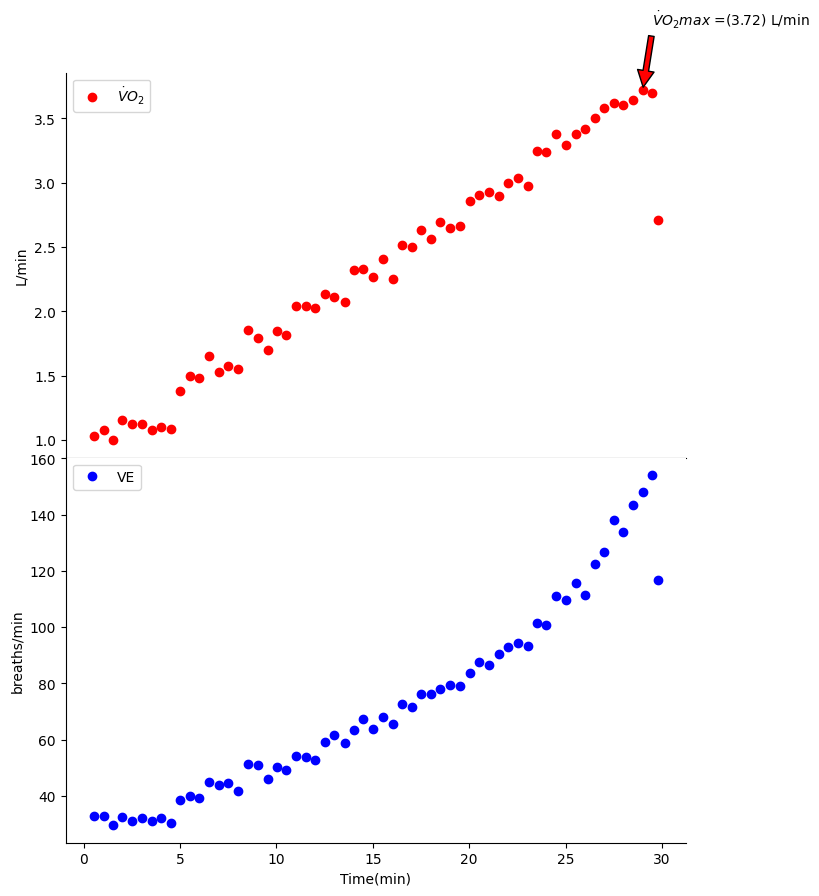

In [2]:
### Now all together in one code block that could run independently...
# lets take care of importing everything we need at once

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Lets read in our file now
df = pd.read_csv('../input/knes381vo2/subject_1432.csv', header=[0], skiprows=[1,2,3])

# please note that while this is an output file from the parvo-metabolics cart we have
# I have edited this data set and simplied the header file on it

# rename our column headers
df = df.rename(columns={'VE/': 'VE/VO2','VE/.1': 'VE/VCO2'})

# simplify our terms to reduce future typing... 
# it is easier to write plot x, y than plot df['Time'], df['VO2']
x = df['TIME']
y = df['VO2']
y1 = df['VE']

# Gas Exchange Threshold (GET) estimation using V-Slope method
# GET occurs when VCO2 vs VO2 slope significantly increases
slope_changes = np.gradient(np.gradient(y))  # Second derivative to find inflection point
GET_index = np.argmax(slope_changes)  # First steepest slope change
GET_vo2 = x.iloc[GET_index]  # VO2 value at GET


#Find VO2 max value 
ymax = max(y)

# find the x position of the ymax value or where ymax occurs on the x axis
xmax = x[y.argmax()]

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 10)) # Note I increased the figure size here.

# this line seperates the two plots...
fig.subplots_adjust(hspace=0)

# annotate the position of V02 max before plotting the value, we could do this later but why.

ax[0].annotate('$\dot VO_2max$ =({}) L/min'.format(round(ymax, 2)), 
               xy=(xmax, ymax), xytext=(xmax+.5, ymax+ .5),
               arrowprops=dict(facecolor='red', shrink= 0.05),
                )

ax[0].plot(x, y, 'o', label=('$\dot VO_2$'), c='r' )
# in the line of code below I hide the top and right black bars serrounding the plot for APA format.
ax[0].spines[['right', 'top']].set_visible(False)
ax[0].set(ylabel=('L/min'))
ax[0].legend()
#note all these set features could be added in one line but reading it would be difficult

# Second plot of values down from the top
ax[1].plot(x, y1, 'o', label=('VE'), c='b')
ax[1].spines[['top', 'right']].set_visible(False)
ax[1].set(ylabel=('breaths/min'))
ax[1].set(xlabel=('Time(min)'))
ax[1].legend()

# save the figure before we show it... or it will be blank
fig.savefig("VO2-VE-4.png", dpi=300, bbox_inches = "tight")
fig.show()

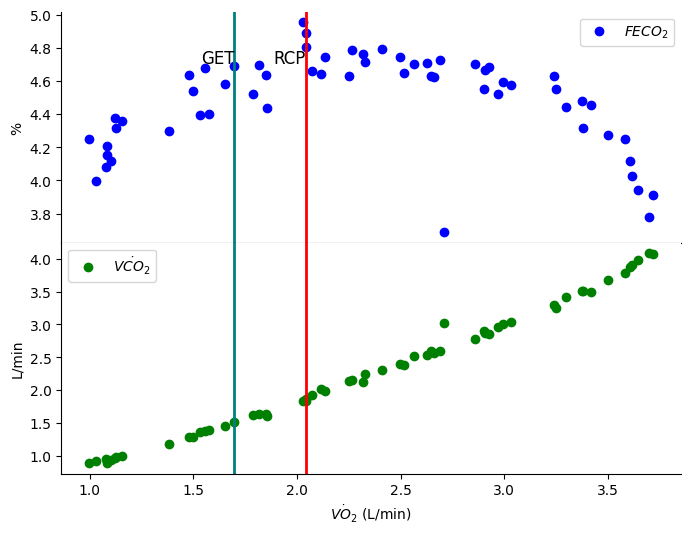

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Read data
df = pd.read_csv('../input/knes381vo2/subject_1432.csv', header=[0], skiprows=[1,2,3])

# Rename columns
df = df.rename(columns={'VCO2': 'VCO2_Lmin', 'FECO2': 'FECO2_percent', 'VE/': 'VE', 'VE/.1': 'VE_VCO2'})

# Define variables
x = df['VO2']  # VO2 (L/min)
y_vco2 = df['VCO2_Lmin']  # VCO2 (L/min)
y_feco2 = df['FECO2_percent']  # FECO2 (%)
ve_vco2 = df['VE_VCO2']  # VE/VCO2

# Compute first derivatives for threshold detection
vco2_slope = np.gradient(y_vco2, x)
feco2_slope = np.gradient(y_feco2, x)

# Use find_peaks to locate significant changes
get_peaks, _ = find_peaks(vco2_slope, height=np.mean(vco2_slope) * 1.5, distance=5)
rcp_peaks, _ = find_peaks(-feco2_slope, height=np.mean(-feco2_slope) * 1.2, distance=30)  # Detecting the dip

# Select the most significant GET point
GET_vo2 = x.iloc[get_peaks[1]] if len(get_peaks) > 1 else None

if len(rcp_peaks) > 0:
    # Find the index of the minimum slope among the rcp_peaks
    prominent_drop_idx = rcp_peaks[np.argmin(feco2_slope[rcp_peaks])]
    # Choose the VO2 value at the rightmost prominent drop
    RCP_vo2 = x.iloc[prominent_drop_idx]  # Choose the VO2 at the corresponding rcp peak
else:
    RCP_vo2 = None


# Create subplots
fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8, 6))
fig.subplots_adjust(hspace=0)

# Plot FECO2 over VO2 (Top Panel)
ax[0].plot(x, y_feco2, 'o', label='$FECO_2$', c='b')
ax[0].set(ylabel='%')
ax[0].legend()
ax[0].spines[['right', 'top']].set_visible(False)

# Plot VCO2 over VO2 (Bottom Panel)
ax[1].plot(x, y_vco2, 'o', label='$\dot{VCO}_2$', c='g')
ax[1].set(ylabel='L/min', xlabel='$\dot{VO}_2$ (L/min)')
ax[1].legend()
ax[1].spines[['right', 'top']].set_visible(False)

# Add vertical lines for GET and RCP
if GET_vo2:
    ax[0].axvline(GET_vo2, color='teal', linestyle='-', linewidth=2, label='GET')
    ax[1].axvline(GET_vo2, color='teal', linestyle='-', linewidth=2)
    ax[0].text(GET_vo2, max(y_feco2) * 0.95, 'GET', color='black', fontsize=12, ha='right')

if RCP_vo2:
    ax[0].axvline(RCP_vo2, color='red', linestyle='-', linewidth=2, label='RCP')
    ax[1].axvline(RCP_vo2, color='red', linestyle='-', linewidth=2)
    ax[0].text(RCP_vo2, max(y_feco2) * 0.95, 'RCP', color='black', fontsize=12, ha='right')

# Save figure
fig.savefig("VO2_VCO2_FECO2_Thresholds.png", dpi=300, bbox_inches="tight")
plt.show()